## Use ENGIE’s open data set

ENGIE provides access to the data of its 'La Haute Borne' wind farm through https://opendata-renewables.engie.com and through an API. The data can be used to create additional turbine objects and gives users the opportunity to work with further real-world data. 

The series of notebooks in the 'examples' folder uses SCADA data downloaded from https://opendata-renewables.engie.com, saved in the 'examples/data' folder. Additional plant level meter, availability, and curtailment data were synthesized based on the SCADA data.

In the following example, data is loaded into a turbine object and plotted as a power curve. The selected turbine can be changed if desired.

In [1]:
from pathlib import Path

import numpy as np
#import databricks.koalas as pd # replaces: 'import pandas as pd'
import matplotlib.pyplot as plt

from bokeh.plotting import show
from bokeh.io import output_notebook
output_notebook()

from openoa.utils import filters
from openoa.utils import power_curve
from openoa.utils import pandas_plotting

from openoa import PlantData

Loading BokehJS ...

### Import the data

The project_ENGIE module is located in the same directory as this notebook. It is a script which implements a function called `prepare` which loads Engie's data from CSV, applies quality control and pre-processing as discussed in the previous notebook, and constructs and returns the PlantData object.

We recommend taking a look at the project_ENGIE script and adapting it to meet your own needs.


In [2]:
import project_ENGIE

project = project_ENGIE.prepare()

INFO:root:Loading SCADA data
INFO:root:SCADA data loaded
INFO:root:Timestamp QC and conversion to UTC
INFO:root:Correcting for out of range of temperature variables
INFO:root:Flagging unresponsive sensors
INFO:root:Converting field names to IEC 61400-25 standard


Now the data is imported we can take a look at the wind farm. There are 4 turbines, nearby foresty, a small town and neighbouring wind farms, which could impact on performance. Now lets have a look at the turbines.

**NOTE**: `plot_windfarm` has been modified to take the asset data frame in place of the whole project
 - TODO: allow for project or asset table input so the method could be attached to the plant class

In [3]:
show(pandas_plotting.plot_windfarm(project.asset,tile_name="OpenMap",plot_width=600,plot_height=600))

ValueError: cannot insert id, already exists

In [4]:
# List of turbines

# turb_list = project.scada.df.id.unique()
turb_list = project.scada.id.unique()
turb_list

array(['R80736', 'R80721', 'R80790', 'R80711'], dtype=object)

Let's examine the first turbine from the list above.

In [7]:
# df = project.scada.df.loc[project.scada.df['id'] == turb_list[0]]
# windspeed = df["wmet_wdspd_avg"]
# power_kw = df["wtur_W_avg"]/1000 # Put into kW

df = project.scada.loc[project.scada.id == turb_list[0]]
windspeed = df.windspeed
power_kw = df.power

In [8]:
def plot_flagged_pc(ws, p, flag_bool, alpha):
    plt.scatter(ws, p, s = 1, alpha = alpha)
    plt.scatter(ws[flag_bool], p[flag_bool], s = 1, c = 'red')
    plt.xlabel('Wind speed (m/s)')
    plt.ylabel('Power (W)')
    plt.show()

First, we'll make a scatter plot the raw power curve data.

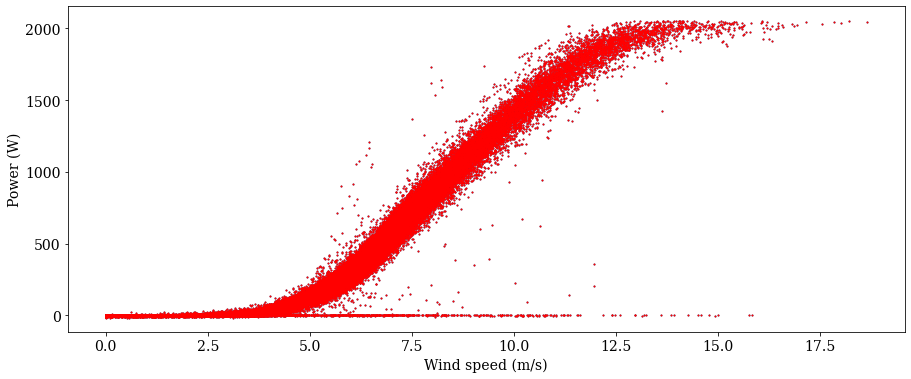

In [9]:
plot_flagged_pc(windspeed, power_kw, np.repeat(True, df.shape[0]), 1)

### Range filter

In [10]:
out_of_range = filters.range_flag(windspeed, below=0, above=70)
windspeed[out_of_range].head()

Series([], Name: windspeed, dtype: float64)

No wind speeds out of range

### Window range filter

Now, we'll apply a window range filter to remove data with power values outside of the window from 20 to 2100 kW for wind speeds between 5 and 40 m/s.

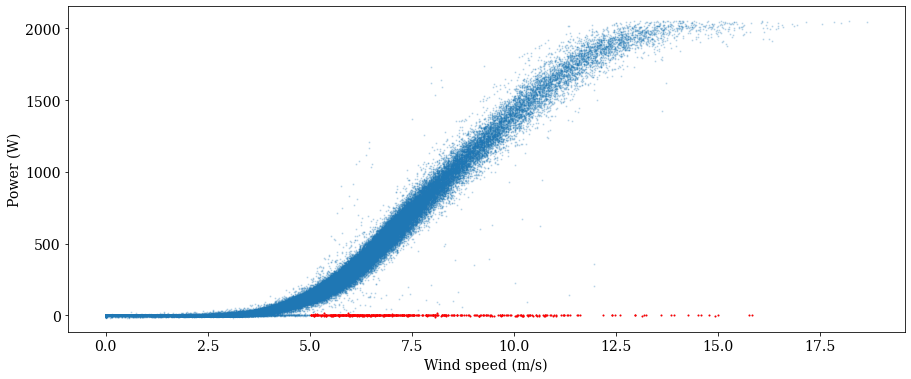

In [11]:
out_of_window = filters.window_range_flag(windspeed, 5., 40, power_kw, 20., 2100.)
plot_flagged_pc(windspeed, power_kw, out_of_window, 0.2)

Let's remove these flagged data from consideration

In [12]:
windspeed_filt1 = windspeed[~out_of_window]
power_kw_filt1 = power_kw[~out_of_window]

### Bin filter

We may be interested in fitting a power curve to data representing 'normal' turbine operation. In other words, we want to flag all anomalous data or data represenatative of underperformance. To do this, the 'bin_filter' function is useful. It works by binning the data by a specified variable, bin width, and start and end points. The criteria for flagging is based on some measure (scalar or standard deviation) from the mean or median of the bin center. 

As an example, let's bin on power in 100 kW increments, starting from 25.0 kW but stopping at 90% of peak power (i.e. we don't want to flag all the data at peak power and high wind speed. Let's use a scalar threshold of 1.5 m/s from the median for each bin. Let's also consider data on both sides of the curve by setting the 'direction' parameter to 'all'

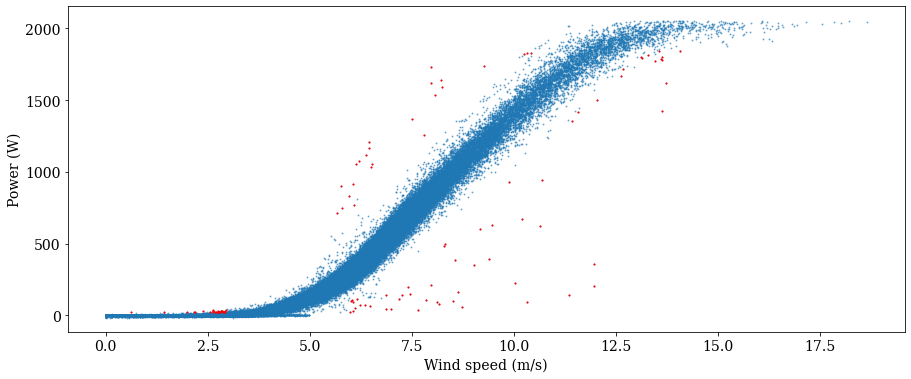

In [13]:
max_bin = 0.90*power_kw_filt1.max()
bin_outliers = filters.bin_filter(power_kw_filt1, windspeed_filt1, 100, 1.5, 'median', 20., max_bin, 'scalar', 'all')
plot_flagged_pc(windspeed_filt1, power_kw_filt1, bin_outliers, 0.5)

As seen above, one call for the bin filter has done a decent job of cleaning up the power curve to represent 'normal' operation, without excessive removal of data points. There are a few points at peak power but low wind speed that weren't flagged, however. Let catch those, and then remove those as well as the flagged data above, and plot our 'clean' power curve 

In [14]:
windspeed_filt2 = windspeed_filt1[~bin_outliers]
power_kw_filt2 = power_kw_filt1[~bin_outliers]

#### Unresponsive Filter

As a final filtering demonstration, we can look for an unrespsonsive sensor (i.e. repeating measurements). In this case, let's look for 3 or more repeating wind speed measurements:

In [15]:
frozen = filters.unresponsive_flag(windspeed_filt2, 3)
windspeed_filt2[frozen]

time                 id    
2014-01-10 14:40:00  R80736    0.0
2014-01-10 14:50:00  R80736    0.0
2014-01-10 15:00:00  R80736    0.0
2014-01-11 22:30:00  R80736    0.0
2014-01-11 22:40:00  R80736    0.0
                              ... 
2015-12-09 22:50:00  R80736    0.0
2015-12-09 23:00:00  R80736    0.0
2015-12-15 02:20:00  R80736    5.5
2015-12-15 02:30:00  R80736    5.5
2015-12-15 02:40:00  R80736    5.5
Name: windspeed, Length: 1926, dtype: float64

We actually found a lot, so let's remove these data as well before moving on to power curve fitting.

Note that many of the unresponsive sensor values identified above are likely caused by the discretization of the data to only two decimal places. However, the goal is to illustrate the filtering process.

In [16]:
windspeed_final = windspeed_filt2[~frozen]
power_kw_final = power_kw_filt2[~frozen]

# Filter out the NaN values (same locations in both data sets)
windspeed_final = windspeed_final[~windspeed_final.isna()]
power_kw_final = power_kw_final[~power_kw_final.isna()]

##### Power curve fitting

We will now consider three different models for fitting a power curve to the SCADA data.

In [17]:
# Fit the power curves
iec_curve = power_curve.IEC(windspeed_final, power_kw_final)
l5p_curve = power_curve.logistic_5_parametric(windspeed_final, power_kw_final)
spline_curve = power_curve.gam(windspeed_final, power_kw_final, n_splines = 20)

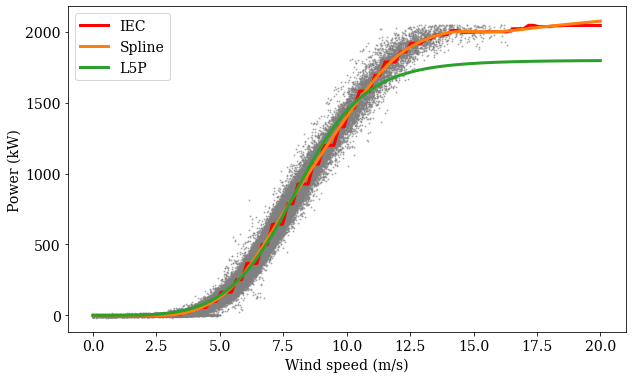

In [18]:
# Plot the results
x = np.linspace(0,20,100)
plt.figure(figsize = (10,6))
plt.scatter(windspeed_final, power_kw_final, alpha=0.5, s = 1, c = 'gray')
plt.plot(x, iec_curve(x), color="red", label = 'IEC', linewidth = 3)
plt.plot(x, spline_curve(x), color="C1", label = 'Spline', linewidth = 3)
plt.plot(x, l5p_curve(x), color="C2", label = 'L5P', linewidth = 3)
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (kW)')
plt.legend()
plt.show()

The above plot shows that the IEC method accurately captures the power curve, although it results in a 'choppy' fit, while the L5P model (constrained by its parametric form) deviates from the knee of the power curve through peak production. The spline fit tends to fit the best.